## Advanced Lane Finding Project

The goals / steps of this project are the following:

1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
2. Apply a distortion correction to raw images.
3. Use color transforms, gradients, etc., to create a thresholded binary image.
4. Apply a perspective transform to rectify binary image ("birds-eye view").
5. Detect lane pixels and fit to find the lane boundary.
6. Determine the curvature of the lane and vehicle position with respect to center.
7. Warp the detected lane boundaries back onto the original image.
8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## 1. Camera Calibration

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

# Compute the calibration matrix
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

## 2. Distortion correction

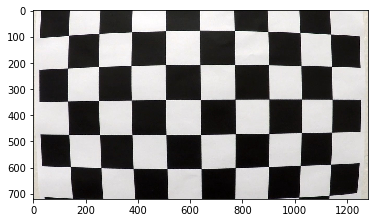

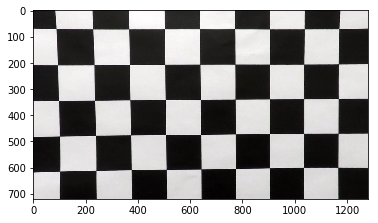

In [2]:
img = cv2.imread('camera_cal/calibration1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
dst = cv2.undistort(img, mtx, dist, None, mtx)
plt.imshow(img)
plt.show()
plt.imshow(dst)
plt.show()

In [3]:
images = glob.glob('test_images/test*.jpg')
for fname in images:
    img = cv2.imread(fname)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    cv2.imshow('img',dst)
    # save the undistort images to output_images folder
    cv2.imwrite(fname.replace("test_images", "output_images"), dst)
    cv2.waitKey(500)
cv2.destroyAllWindows()

## 3. Creating binary image

In [4]:
# sobel operation
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient=='x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel>=thresh[0])&(scaled_sobel<=thresh[1])] = 1
    return grad_binary

# magnitude of the gradient
def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag>=mag_thresh[0])&(gradmag<=mag_thresh[1])] = 1
    return mag_binary

# direction of the gradient
def dir_thresh(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_binary = np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return dir_binary

# hls color selection
def hls_thresh(image, thresh=(0,255)):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    S = hls[:,:,2]
    color_binary = np.zeros_like(S)
    color_binary[(S>=thresh[0])&(S<=thresh[1])] = 1
    return color_binary

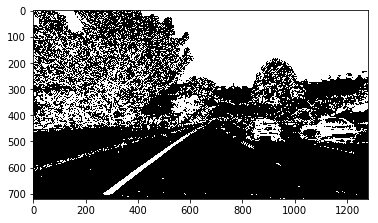

In [5]:
fname = "output_images/test6.jpg"
img = cv2.imread(fname)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

gradx = abs_sobel_thresh(img, 'x', 5, (20, 100))
grady = abs_sobel_thresh(img, 'y', 5, (20, 100))
mag_binary = mag_thresh(img, 9, (30, 100))
dir_binary = dir_thresh(img, 15, (0.7, 1.3))
color_binary = hls_thresh(img, (90, 255))

# combine together
combined = np.zeros_like(color_binary)
combined[((gradx==1)&(grady==1)) | ((mag_binary==1)&(dir_binary==1)) | color_binary==1] = 1
plt.imshow(combined, cmap='gray')

# 4. Perspective transform

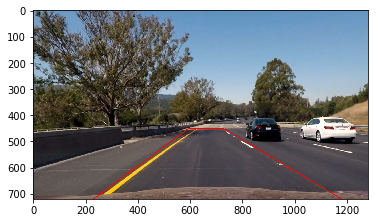

In [6]:
vertices = [(230,720),(595,450),(725,450),(1180,720)]
cv2.line(img, vertices[0], vertices[1], (255,0,0), 2)
cv2.line(img, vertices[1], vertices[2], (255,0,0), 2)
cv2.line(img, vertices[2], vertices[3], (255,0,0), 2)
cv2.line(img, vertices[3], vertices[0], (255,0,0), 2)
plt.imshow(img)

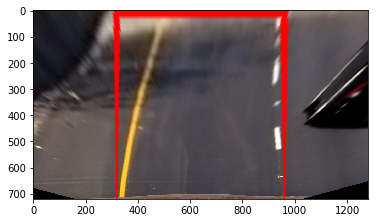

In [7]:
dst = [(320,720),(320,0),(960,0),(960,720)]
img_size = (img.shape[1], img.shape[0])
M = cv2.getPerspectiveTransform(np.float32(vertices), np.float32(dst))
warped = cv2.warpPerspective(img, M, img_size, cv2.INTER_LINEAR)
plt.imshow(warped)

# 5. Lane Detection

(720, 0)

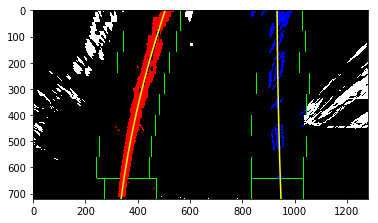

In [13]:
binary_warped = cv2.warpPerspective(combined, M, img_size, cv2.INTER_LINEAR)

def laneDectect(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[200:midpoint]) + 200
    rightx_base = np.argmax(histogram[midpoint:1080]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    return leftx, lefty, left_fitx, rightx, righty, right_fitx, out_img

leftx, lefty, left_fitx, rightx, righty, right_fitx, out_img = laneDectect(binary_warped)   

ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

# 6. Determining the curvature of the lane

In [14]:
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension
y_eval = np.max(ploty)

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')

radius = (left_curverad+right_curverad)/2
offset = ((left_fitx[360] + right_fitx[360])/2 - 640) * xm_per_pix

1146.59546506 m 7771.01514121 m


# 7. Warping back

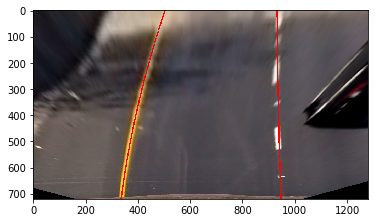

In [15]:
img = cv2.imread(fname)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
warped = cv2.warpPerspective(img, M, img_size)
for i in range(len(ploty)):
    cv2.circle(warped, (int(left_fitx[i]), int(ploty[i])), 2, (255,0,0), 1)
    cv2.circle(warped, (int(right_fitx[i]), int(ploty[i])), 2, (255,0,0), 1)
plt.imshow(warped)

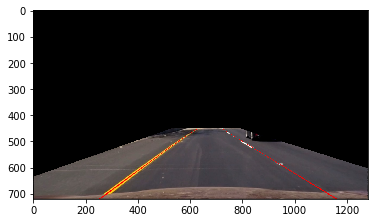

In [16]:
Minv = cv2.getPerspectiveTransform(np.float32(dst), np.float32(vertices))
warped_back = cv2.warpPerspective(warped, Minv, img_size)
plt.imshow(warped_back)

# 8. Visual Output

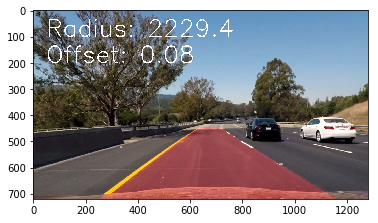

In [17]:
warped = cv2.warpPerspective(combined, M, img_size, cv2.INTER_LINEAR)

def warpBackAndDraw(img, warped, Minv, left_fitx, right_fitx, radius, offset):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_(pts), 255)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    img_size = (img.shape[1], img.shape[0])
    newwarp = cv2.warpPerspective(color_warp, Minv, img_size) 

    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)

    # Combine the text information
    cv2.putText(result, "Radius: "+str(round((radius)/2,2)), (50,100), cv2.FONT_HERSHEY_SIMPLEX, 3, (255,255,255),3)
    cv2.putText(result, "Offset: "+str(round((offset)/2,2)), (50,200), cv2.FONT_HERSHEY_SIMPLEX, 3, (255,255,255),3)
    return result

result = warpBackAndDraw(img, warped, Minv, left_fitx, right_fitx, radius, offset)
plt.imshow(result)

# Processing video

In [18]:
def process(img):
    # undistortion
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.undistort(img, mtx, dist, None, mtx)
    
    # thresh
    gradx = abs_sobel_thresh(img, 'x', 5, (20, 100))
    grady = abs_sobel_thresh(img, 'y', 5, (20, 100))
    mag_binary = mag_thresh(img, 9, (30, 100))
    dir_binary = dir_thresh(img, 15, (0.7, 1.3))
    color_binary = hls_thresh(img, (90, 255))
    combined = np.zeros_like(color_binary)
    combined[((gradx==1)&(grady==1)) | ((mag_binary==1)&(dir_binary==1)) | color_binary==1] = 1
    
    # warp
    src = [(230,720),(595,450),(725,450),(1180,720)]
    dst = [(320,720),(320,0),(960,0),(960,720)]
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(np.float32(src), np.float32(dst))
    warped = cv2.warpPerspective(combined, M, img_size, cv2.INTER_LINEAR)
    
    # lane detect and compute curvature
    leftx, lefty, left_fitx, rightx, righty, right_fitx, _ = laneDectect(warped)
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    radius = (left_curverad+right_curverad)/2
    offset = ((left_fitx[360] + right_fitx[360])/2 - 640) * xm_per_pix
    
    # warp back and draw
    Minv = cv2.getPerspectiveTransform(np.float32(dst), np.float32(src))
    output = warpBackAndDraw(img, warped, Minv, left_fitx, right_fitx, radius, offset)
    output = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
    
    return output

In [19]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

clip = VideoFileClip('project_video.mp4')
output = clip.fl_image(process)
%time output.write_videofile("output_video.mp4", audio=False)

[MoviePy] >>>> Building video output_video.mp4
[MoviePy] Writing video output_video.mp4


100%|█████████▉| 1260/1261 [05:40<00:00,  4.10it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video.mp4 

CPU times: user 8min 53s, sys: 51.2 s, total: 9min 44s
Wall time: 5min 42s
